# A Case-based Explanation Method for Weather Forecasting

# Import all necessary libraries

In [1]:
import pandas as pd
import numpy
import numpy as np
import math
import scipy
from scipy import signal
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerLine2D
from numpy import hstack
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

## All about the Artificial Neural Network

### Load dataset

In [2]:
df_temp = pd.read_csv("weatherdata.csv", parse_dates= True, index_col= 1)
df_temp.head()

,DATE,TEMP_MAX,TEMP_MIN,TEMP_AVG,PRES_AVG,PRES_MAX,PRES_MIN,HUM_AVG,HUM_MAX,HUM_MIN
MONTH,,,,,,,,,,
JANUARY,2000-01-01,29.9,19.2,24.55,23.1,25.3,18.5,80.0,96.0,55.0
JANUARY,2000-01-02,31.6,21.0,26.30,24.9,27.6,23.2,78.0,93.0,53.0
JANUARY,2000-01-03,31.2,20.0,25.60,25.0,29.3,23.3,83.0,99.0,54.0
JANUARY,2000-01-04,30.8,18.8,24.80,24.5,27.1,22.8,87.0,99.0,55.0
JANUARY,2000-01-05,23.8,18.8,21.30,21.3,23.2,19.2,87.0,96.0,72.0


### Global plot

### Process dataset
Split dataset into sequences and define train and prediction columns. In this case, predict average temperature through other measures: pressure and hummidity

In [3]:
step_days = 14
dataset = df_temp.filter(['HUM_MIN','HUM_AVG','HUM_MAX','PRES_MIN','PRES_AVG','PRES_MAX','TEMP_MIN','TEMP_AVG','TEMP_MAX']).values
dataset = np.array(dataset)

def split_sequences(sequences, n_steps):
    inputnn, target = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix + 1 > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix], sequences[end_ix, (1,4,7)]
        inputnn.append(seq_x)
        target.append(seq_y)
    return array(inputnn), array(target)

inputnn, target = split_sequences(dataset, step_days)

In [4]:
inputnn[6,:,1]

array([84., 80., 79., 81., 79., 75., 78., 77., 73., 66., 70., 72., 74.,
       76.])

### Split trainning tests

In [5]:
input_train, input_test, target_train, target_test = train_test_split(inputnn, target, test_size = 0.30, random_state=4,shuffle=True)

In [6]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', return_sequences = True, input_shape = (step_days ,input_train.shape[2])))
model.add(LSTM(32, activation = 'relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(3))
model.compile(optimizer = 'adam', loss = 'mse')
history = model.fit(input_train, target_train, validation_data = (input_test, target_test),batch_size = 16, epochs = 100)

Epoch 1/100
299/299 [==============================] - 5s 12ms/step - loss: 1443.9801 - val_loss: 73.9898
Epoch 2/100
299/299 [==============================] - 3s 10ms/step - loss: 306.6862 - val_loss: 48.2367
Epoch 3/100
299/299 [==============================] - 3s 10ms/step - loss: 214.0199 - val_loss: 47.6263
Epoch 4/100
299/299 [==============================] - 3s 10ms/step - loss: 175.7630 - val_loss: 35.8657
Epoch 5/100
299/299 [==============================] - 3s 10ms/step - loss: 149.6219 - val_loss: 52.0475
Epoch 6/100
299/299 [==============================] - 3s 10ms/step - loss: 141.6228 - val_loss: 26.7388
Epoch 7/100
299/299 [==============================] - 3s 10ms/step - loss: 167.7722 - val_loss: 31.3292
Epoch 8/100
299/299 [==============================] - 3s 10ms/step - loss: 141.1734 - val_loss: 29.4787
Epoch 9/100
299/299 [==============================] - 3s 9ms/step - loss: 145.1206 - val_loss: 53.2943
Epoch 10/100
299/299 [==============================] -

299/299 [==============================] - 3s 9ms/step - loss: 61.4089 - val_loss: 20.4639
Epoch 80/100
299/299 [==============================] - 3s 9ms/step - loss: 62.2319 - val_loss: 20.8967
Epoch 81/100
299/299 [==============================] - 3s 10ms/step - loss: 60.2167 - val_loss: 21.1198
Epoch 82/100
299/299 [==============================] - 3s 9ms/step - loss: 60.6202 - val_loss: 20.7509
Epoch 83/100
299/299 [==============================] - 3s 9ms/step - loss: 60.2018 - val_loss: 23.1191
Epoch 84/100
299/299 [==============================] - 3s 9ms/step - loss: 59.8887 - val_loss: 20.0465
Epoch 85/100
299/299 [==============================] - 3s 9ms/step - loss: 60.7398 - val_loss: 18.9374
Epoch 86/100
299/299 [==============================] - 3s 9ms/step - loss: 58.3246 - val_loss: 23.1308
Epoch 87/100
299/299 [==============================] - 3s 9ms/step - loss: 60.5745 - val_loss: 20.0884
Epoch 88/100
299/299 [==============================] - 3s 10ms/step - loss:

### Plot global RMSE

### Plot RMSE of the training split

In [7]:
prediction_train = model.predict(input_train)

RMSE = math.sqrt(np.square(np.subtract(prediction_train, target_train)).mean())

print("Root Mean Square Error Train:\n",RMSE)

Root Mean Square Error Train:
 3.8834078103868555


### Plot RMSE of the test split

In [8]:
prediction = model.predict(input_test)

RMSE = math.sqrt(np.square(np.subtract(prediction, target_test)).mean())
 
print("Root Mean Square Error Train:\n", RMSE)

Root Mean Square Error Train:
 3.9399629560596328


In [9]:
#     sb.pairplot(dataframe.dropna(), hue='clase',size=4,vars=["duración","paginas","acciones","valor"],kind="reg")


## Analysis Processing

### Initialization of variables and constants

The following cell defines all constants and variables with the data to process.
- Windows variable holds the temperature average, humidity average and vapor pressure average data, avoiding the rest of the data.
- The second line emulates the pop method. It stores the last element of the window variable as the targetWindow variable and then that one is deleted by overwritten the windows variable.
- It defines the windowsLen variable by windows variable length.
- It defines the componentesLen variable by the third dimension of windos variable. In this case, there are 3 components, which are the average temperature, average humidity and vapor average pressure.


In [10]:
nonOutputColumns=[0,2,3,5,6,8]
windows = np.delete(inputnn, nonOutputColumns, 2)
targetWindow, windows = windows[-1], windows[:-1]
windowsLen = len(windows)
componentsLen = windows.shape[2]
windowLen = windows.shape[1]
actualPrediction = prediction[-1]
titleColumns = ["Humidity", "Vapor Pressure" ,"Temperature"]
titleIndexes = ["Window Index {0}".format(index) for index in range(windowsLen)]
smoothnessFactor = .03
punishedSumFactor = .5
finalWindowNumber = 30
#0 number of results, 1 average, 2 Max values, 3 min values, 4 median
explicationMethodResult = 1

### Obtaining the Pearson's correlation

The Pearson's correlation is calculated using comprehensive lists. The pearsonCorrelation variable has the same shape as windows variable.
- It uses the corrcoef method from Numpy to acomplish this.
- The results are obtained by performing the operation as if it was the axis = 1. 
- It's necessary to reshape in order to get the same shape as it was mentioned before.

In [11]:
pearsonCorrelation = np.array(([np.corrcoef(windows[currentWindow,:,currentComponent], targetWindow[:,currentComponent])[0][1]
for currentWindow in range(len(windows)) for currentComponent in range(componentsLen)])).reshape(-1,componentsLen)

### Pearson´s correlation print 

In [12]:
df = pd.DataFrame(data = pearsonCorrelation, columns= titleColumns, index = titleIndexes)
df

,Humidity,Vapor Pressure,Temperature
Window Index 0,0.465358,-0.006805,0.077588
Window Index 1,0.257798,-0.041508,0.278657
Window Index 2,0.289051,-0.118465,-0.038017
Window Index 3,0.127883,-0.155410,-0.347418
Window Index 4,0.101848,-0.242479,-0.245252
...,...,...,...
Window Index 6827,-0.147868,-0.381464,0.110078
Window Index 6828,0.207013,-0.296889,0.097895
Window Index 6829,0.085850,-0.126142,-0.043407
Window Index 6830,-0.178847,0.360006,-0.382395


### Obtaining the Euclidean distance

The Euclidian distance is also calculated using comprehensive lists.
- It uses the linalg.norm function from Numpy.

As Pearson's correlation, the results are obtained by performing the operation as if it was the axis = 1.
- It's necessary applying the reshape just like Pearson´s correlation is applied.

In [13]:
euclideanDistance = np.array(([np.linalg.norm(targetWindow[:,currentComponent] - windows[currentWindow,:,currentComponent])
for currentWindow in range(windowsLen) for currentComponent in range(componentsLen)])).reshape(-1,componentsLen)

In [18]:
def dtw(A,B):
    
    N = A.shape[0]
    M = B.shape[0]
    dist_mat= np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            dist_mat[i, j] = abs(A[i] - B[j])
    
    # Initialize the cost matrix
    cost_mat = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        cost_mat[i, 0] = np.inf
    for i in range(1, M + 1):
        cost_mat[0, i] = np.inf

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],      # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1
        elif tb_type == 1:
            # Insertion
            i = i - 1
        elif tb_type == 2:
            # Deletion
            j = j - 1
        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    return (cost_mat[N - 1, M - 1])

In [19]:
dynamicTimeWarping = np.array(([dtw(targetWindow[:,currentComponent],windows[currentWindow,:,currentComponent])for currentWindow in range(windowsLen) for currentComponent in range(componentsLen)])).reshape(-1,componentsLen)

In [122]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalizedDTW= scaler.fit_transform(np.sum(scaler.fit_transform(dynamicTimeWarping), axis=1).reshape(-1,1)).reshape(1,-1)[0]*-1+1
normalizedDTW

array([0.49437988, 0.4834263 , 0.4482009 , ..., 0.98772691, 0.99360533,
       1.        ])

In [123]:
normalizedDTW

array([0.49437988, 0.4834263 , 0.4482009 , ..., 0.98772691, 0.99360533,
       1.        ])

### Euclidean distance print 

In [36]:
df = pd.DataFrame(data = euclideanDistance, columns= titleColumns, index = titleIndexes)
df

,Humidity,Vapor Pressure,Temperature
Window Index 0,29.142680,35.048009,18.276761
Window Index 1,32.760435,36.124597,18.285513
Window Index 2,37.263248,38.831628,19.480696
Window Index 3,42.100640,41.205146,21.038180
Window Index 4,45.135287,43.253922,21.982891
...,...,...,...
Window Index 6827,22.946183,6.556789,3.114482
Window Index 6828,18.940411,6.270030,2.873587
Window Index 6829,19.804747,5.899212,2.846050
Window Index 6830,22.692295,4.472908,3.383785


### Normalized Euclidean distance

Euclidean distance is normalized in order to get values from 0 o 1. The normalization is applied for each component respectively.

In [37]:
normalizedEuclideanDistance = euclideanDistance / np.amax(euclideanDistance,axis=0)

### Normalized Euclidean distance print

In [38]:
df = pd.DataFrame(data = normalizedEuclideanDistance, columns= titleColumns, index = titleIndexes)
df

,Humidity,Vapor Pressure,Temperature
Window Index 0,0.122758,0.556000,0.489366
Window Index 1,0.137997,0.573079,0.489600
Window Index 2,0.156965,0.616023,0.521601
Window Index 3,0.177341,0.653676,0.563304
Window Index 4,0.190124,0.686178,0.588598
...,...,...,...
Window Index 6827,0.096657,0.104017,0.083391
Window Index 6828,0.079783,0.099467,0.076941
Window Index 6829,0.083424,0.093585,0.076204
Window Index 6830,0.095587,0.070958,0.090602


### Obtaining the normalization between the Pearson's correlation and Euclidean distance

To do so, the following equation was used:
    
    

In [39]:
normalizedCorrelation = (.5+(pearsonCorrelation-2*normalizedEuclideanDistance+1)/4)

In [40]:
normalizedCorrelation

array([[0.8049603 , 0.47029885, 0.52471411],
       [0.74545083, 0.45308375, 0.57486422],
       [0.74378036, 0.41237231, 0.47969493],
       ...,
       [0.72975045, 0.67167211, 0.7010464 ],
       [0.65749463, 0.80452255, 0.60910021],
       [0.65310419, 0.90379774, 0.75651838]])

### Normalized Correlation print

In [41]:
df = pd.DataFrame(data = normalizedCorrelation, columns= titleColumns, index = titleIndexes)
df

,Humidity,Vapor Pressure,Temperature
Window Index 0,0.804960,0.470299,0.524714
Window Index 1,0.745451,0.453084,0.574864
Window Index 2,0.743780,0.412372,0.479695
Window Index 3,0.693300,0.384309,0.381494
Window Index 4,0.680400,0.346291,0.394388
...,...,...,...
Window Index 6827,0.664705,0.602626,0.735824
Window Index 6828,0.761862,0.626044,0.736003
Window Index 6829,0.729750,0.671672,0.701046
Window Index 6830,0.657495,0.804523,0.609100


### Normalized Correlation sum and punished sum 

As is possible in Python, first it's applied the punished sum to normalizedCorrelation variable and then the Numpy's sum function is used by setting axis = 1 as an argument. Finally, the result is stored in the correlationPerWindow variable.

In the second line, the correlationPerWindow variable is normalized in order to get values from 0 to 1.


In [42]:
correlationPerWindow = np.sum(((normalizedCorrelation+punishedSumFactor)**2), axis=1)


In [43]:
max(correlationPerWindow)

5.553822899397686

In [90]:
correlationPerWindow = scaler.fit_transform(correlationPerWindow.reshape(-1,1)).reshape(1,-1)[0]

In [45]:
dff = pd.DataFrame(correlationPerWindow)
dff

,0
0,0.665207
1,0.650876
2,0.601246
3,0.537107
4,0.523870
...,...
6827,0.738155
6828,0.790082
6829,0.779214
6830,0.769142


### Normalized Correlation per Window sum print

In [46]:
df = pd.DataFrame(data = correlationPerWindow, columns= ["Similarity per window"], index = titleIndexes)
df

,Similarity per window
Window Index 0,0.665207
Window Index 1,0.650876
Window Index 2,0.601246
Window Index 3,0.537107
Window Index 4,0.523870
...,...
Window Index 6827,0.738155
Window Index 6828,0.790082
Window Index 6829,0.779214
Window Index 6830,0.769142


### Correlation per window plot

The following figure shows the correlation value of each window, being the correlation the similarity compared to targetWindow variable.

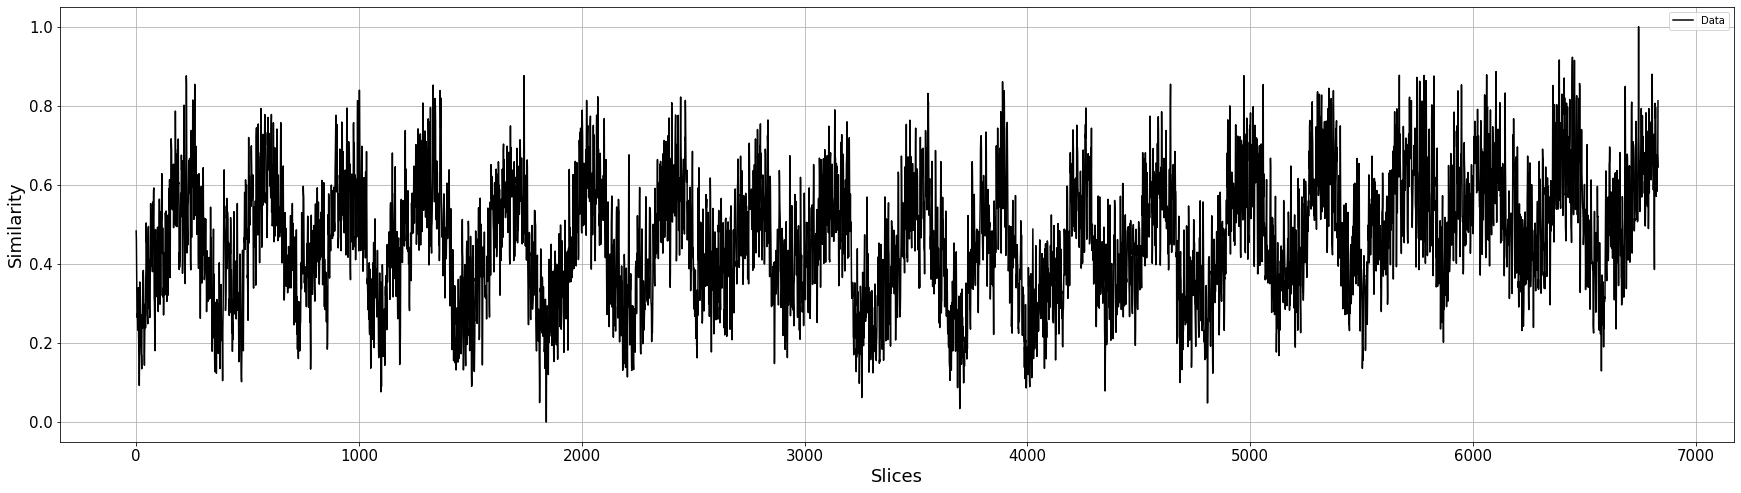

In [78]:
plt.figure(figsize=(30,8))
plt.plot(correlationPerWindow,'k', label='Data')
plt.ylabel('Similarity',fontsize=18)
plt.xlabel('Slices',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.legend()
plt.show()

## Highest values filtering

As a first step, the time series tendency is discovered.

- To acomplish this the Hodrick-Prescott filter implemented as a function in the Statsmodel module is used.
- In the following cell the tendency component and cyclic component are obtained.

In [79]:
cyclicComponent, tendencyComponent = sm.tsa.filters.hpfilter(correlationPerWindow)

### Tendency time series plot

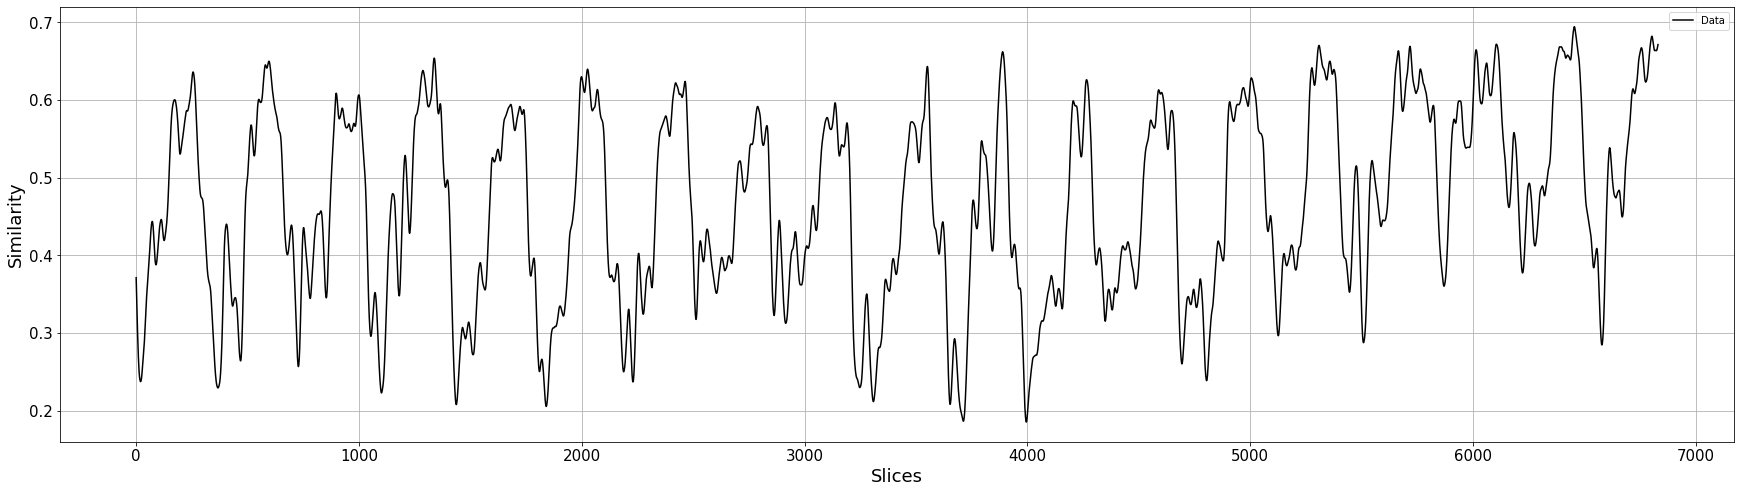

In [80]:
plt.figure(figsize=(30,8))
plt.plot(tendencyComponent,'k', label='Data')
plt.ylabel('Similarity',fontsize=18)
plt.xlabel('Slices',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.legend()
plt.show()

### Noise Reduction

It can be observed the kind of pattern of the time series.

Now it's a little more obvious where and which the peaks are, but there are still some peaks so near by others that they could be considered as noise.

The following figure shows the problem mentioned before.

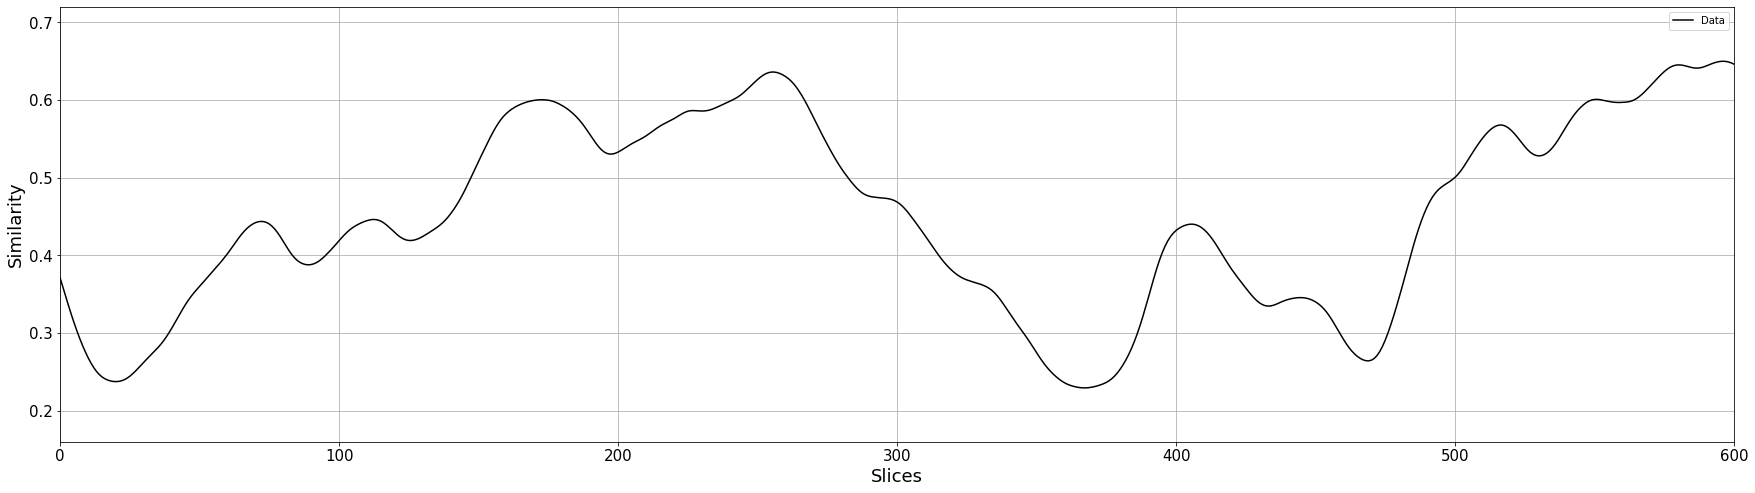

In [81]:
plt.figure(figsize=(30,8))
plt.plot(tendencyComponent,'k', label='Data')
plt.ylabel('Similarity',fontsize=18)
plt.xlabel('Slices',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,600)
plt.grid()
plt.legend()
plt.show()

### Noise removing

To remove the noise, the Local Regression implemented as a function in the same statsmodels module is used,this is performed in order to get a better results without many peaks near others.

- In the first time the argument in the frac parameter of lowess function is 1%

In [91]:
df_loess_1 = pd.DataFrame(lowess(correlationPerWindow, np.arange(len(correlationPerWindow)), frac=0.03)[:, 1])

In the figure below it can be observed tha the result is so similar to the tendency component, what it means that is workable way to continue smoothing but there is still some noise.

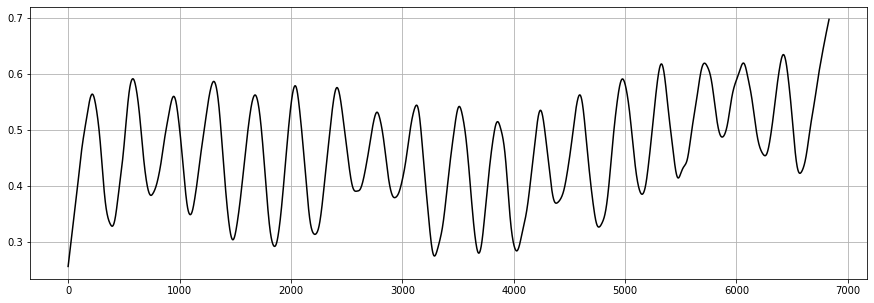

In [92]:
plt.figure(figsize=(15,5))
plt.plot(df_loess_1, 'k', label='Data')
plt.grid()
plt.show()

To get better results, the frac parameter is setted to 3%
- The smoothedCorrelation variable is overwritten to store only the data needed which is the smoothed time series data.

In [93]:
smoothedCorrelation = lowess(correlationPerWindow, np.arange(len(correlationPerWindow)), smoothnessFactor)[:,1]
df_loess_3 = pd.DataFrame(smoothedCorrelation)

In [124]:
smoothedDTW = lowess(normalizedDTW, np.arange(len(normalizedDTW)), smoothnessFactor)[:,1]

Now the result presented in the following figure has no peaks near by others such as the figures above.

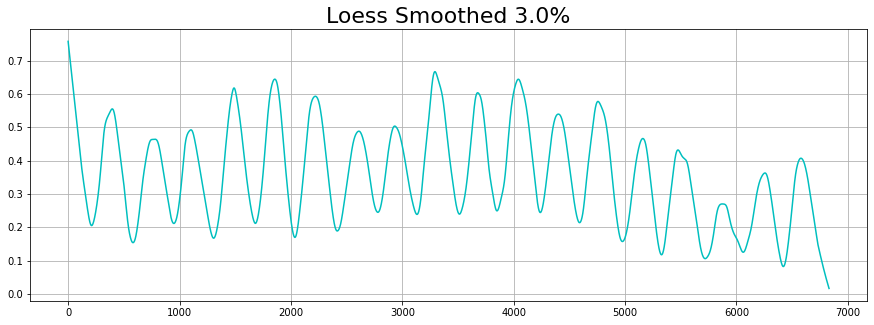

In [115]:
plt.figure(figsize=(15,5))
plt.plot(smoothedDTW, 'c', label='Data')
plt.title("Loess Smoothed {0}%".format(smoothnessFactor*100), fontsize=22)
plt.grid()
plt.show()

For purposes of this problem, all noise peaks have been removed.

### Time series peaks finding

The peaks and valleys are useful to determine the best and worst comparison cases to windowTarget variable.

- To know the peaks and valleys the argrelextrema function from scipy is used.
- The the results of the following cell is the peak indexes and valleys indexes.
- The function returns a lots information but the only want needed are the index of peaks and valleys.

In [95]:
valleyIndex, peakIndex = signal.argrelextrema(smoothedCorrelation, np.less)[0], signal.argrelextrema(smoothedCorrelation, np.greater)[0]


In [125]:
valleyIndexDTW, peakIndexDTW = signal.argrelextrema(smoothedDTW, np.less)[0], signal.argrelextrema(smoothedDTW, np.greater)[0]

The peaks and valleys indexes are shown in the figure below

In [126]:
print(peakIndex)
print(peakIndexDTW)
print(valleyIndex)
print(valleyIndexDTW)

[ 217  581  948 1307 1678 2038 2414 2773 3128 3511 3855 4240 4593 4977
 5326 5713 6062 6421]
[ 211  583  949 1306 1681 2036 2416 2781 3132 3513 3850 4239 4592 4976
 5327 5719 6061 6421]
[ 395  744 1097 1479 1853 2215 2584 2931 3289 3687 4027 4381 4764 5152
 5477 5872 6256 6570]
[ 396  781 1103 1489 1855 2220 2610 2932 3293 3677 4042 4402 4757 5159
 5475 5873 6256 6579]


Due to regression local nature, smoothedCorrelation variable do not match with the original peaks and valleys of normalizedCorrelation. To know the real peaks or correlationPerWindow, it's necessary do the following:

- Use peak indexes to split and for each segment detect the highest correlation value.
- Use valley indexes to spplit and for each segment detect the lowes correlation value.

- peakSegment variable contains all the peak segments.
- valleySegment variable contains all the valley segments.

### Split into segments based on worst and best indices

It creates to arrays which contains the segments.
- The concaveSegments contains the segments with the highest values of correlationPerWindow.
- The convexSegments contains the segments with the lowest values of correlationPerWindow.

In [119]:
concaveSegments = np.split(np.transpose(np.array((np.arange(windowsLen), correlationPerWindow))), valleyIndex)
convexSegments = np.split(np.transpose(np.array((np.arange(windowsLen), correlationPerWindow))), peakIndex)


In [121]:
normalizedDTW

array([0.50562012, 0.5165737 , 0.5517991 , ..., 0.01227309, 0.00639467,
       0.        ])

In [127]:
concaveSegmentsDTW = np.split(np.transpose(np.array((np.arange(windowsLen), normalizedDTW))), valleyIndexDTW)
convexSegmentsDTW = np.split(np.transpose(np.array((np.arange(windowsLen), normalizedDTW))), peakIndexDTW)

### Peak segments and valley segments plot

### Detection of the highest and lowest value of each segment

It creates two list which store the indexes.
- The bestWindowIndex variable stores the indices with the highest correlation values.
- The worstWindowIndex variable stores the indices with the lowest correlation values.

In [128]:
bestWindowsIndex, worstWindowsIndex, bestWindowsIndexDTW, worstWindowsIndexDTW = list(), list() , list(), list()

for split in concaveSegments:
    bestWindowsIndex.append(int(split[np.where(split == max(split[:,1]))[0][0],0]))
for split in convexSegments:
    worstWindowsIndex.append(int(split[np.where(split == min(split[:,1]))[0][0],0]))

353

In [129]:
bestDic = {index: correlationPerWindow[index] for index in bestWindowsIndex}
worstDic = {index: correlationPerWindow[index] for index in worstWindowsIndex}

In [131]:
bestDicDTW

{263: 0.898581336230653,
 613: 0.9115874382747693,
 979: 0.8653369504052562,
 1264: 0.8891410135874276,
 1710: 0.8478600737248516,
 2011: 0.8903642432902525,
 2466: 0.8773533901547169,
 2783: 0.8404212663461793,
 3182: 0.8209849721170093,
 3544: 0.8753620624478011,
 3899: 0.9265894515708659,
 4252: 0.8676734763355383,
 4581: 0.835993038520837,
 5013: 0.9133222864920358,
 5341: 0.9243315525424288,
 5720: 0.9554192434067706,
 6113: 0.9360915912270737,
 6464: 0.9511854363728667,
 6831: 1.0}

In [132]:
bestSorted = sorted(bestDic.items(),reverse=True, key=lambda x:x[1])
worstSorted = sorted(worstDic.items(), key=lambda x:x[1])

Printing the best and worst correlations indexes along their corresponding values

The following figure shows the  found index for the peaks in the smoothedCorrelation variable and its corresponding value indexed in correlationPerWindow variable.

In [133]:
maxComp,minComp,lims=[],[],[]
for i in range(componentsLen):
    maxComp.append(int(max(max(a) for a in windows[:,:,i])))
    minComp.append(int(min(min(a) for a in windows[:,:,i])))
    lims.append(range(minComp[i],maxComp[i],int((maxComp[i]-minComp[i])/8)))

In [181]:
windows[bestSorted[i][0]+1][windowLen-1][f]-actualPrediction[f]

-0.3961296081542969

In [184]:
actualPrediction

array([80.299736, 27.390612, 28.14613 ], dtype=float32)

In [183]:
maxComp

[107, 42, 34]

In [187]:
normalizedActualPrediction = (actualPrediction-minComp)/maxComp

In [193]:
bestMAE,worstMAE = [],[]
for i in range(len(bestSorted)):
    rawBestMAE=rawWorstMAE=0
    for f in range(componentsLen):
        rawBestMAE+=(((windows[bestSorted[i][0]][windowLen-1][f]-minComp[f])/maxComp[f])-normalizedActualPrediction[f])
        rawWorstMAE+=((windows[worstSorted[i][0]][windowLen-1][f]-minComp[f])/maxComp[f]-normalizedActualPrediction[f])
    bestMAE.append(rawBestMAE/componentsLen) 
    worstMAE.append(rawWorstMAE/componentsLen)

In [143]:
d= {'index': dict(bestSortedDTW).keys(), 'CCI': dict(bestSortedDTW).values(), "MAE":bestMAEDTW,'index.1': dict(worstSortedDTW).keys(), 'CCI.1': dict(worstSortedDTW).values(), "MAE.1":worstMAEDTW}
df = pd.DataFrame(data = d)
df

,index,CCI,MAE,index.1,CCI.1,MAE.1
0,6831,1.000000,0.531983,3989,0.000000,0.254284
1,5720,0.955419,0.539796,3654,0.037374,0.368963
2,6464,0.951185,0.511878,1841,0.066425,0.304575
3,6113,0.936092,0.537103,3300,0.088516,0.277346
4,3899,0.926589,0.512413,2226,0.110110,0.396284
5,5341,0.924332,0.535202,1443,0.112960,0.329102
6,5013,0.913322,0.506556,380,0.126673,0.340412
7,613,0.911587,0.498505,1110,0.127197,0.296123
8,263,0.898581,0.508430,733,0.134607,0.363106
9,2011,0.890364,0.511632,4809,0.134746,0.241105


In [144]:
d= {'index': dict(bestSorted).keys(), 'CCI': dict(bestSorted).values(), "MAE":bestMAE,'index.1': dict(worstSorted).keys(), 'CCI.1': dict(worstSorted).values(), "MAE.1":worstMAE}
df = pd.DataFrame(data = d)
df

,index,CCI,MAE,index.1,CCI.1,MAE.1
0,6744,1.000000,0.473211,1841,0.000000,0.304575
1,6447,0.922810,0.506829,3697,0.033914,0.267785
2,6104,0.886331,0.513824,4809,0.048225,0.241105
3,5670,0.877206,0.491887,3257,0.061779,0.318216
4,1741,0.876201,0.483111,1099,0.076303,0.297968
5,4972,0.876195,0.465373,4349,0.078535,0.388419
6,225,0.875737,0.475584,3995,0.086118,0.326055
7,3889,0.860950,0.476766,1506,0.090385,0.228984
8,4643,0.854542,0.437775,14,0.092639,0.329896
9,1333,0.852224,0.465644,473,0.101911,0.393364


In [151]:
sum(bestMAEDTW)/len(bestMAEDTW)

0.3347007776900057

In [42]:
def notCombinedOption():
    color=[".-b",".-g",".-m"]
    color2=["db","dg","dm"]
    for i in range(len(bestSorted)):
        plt.figure(figsize=(12,8))
        for f in range(componentsLen):
            plt.subplot(componentsLen,1,f+1)
            plt.title(titleColumns[f])
            plt.plot(cont,targetWindow[:,f], '.-k', label = "Target")
            plt.plot(cont,windows[bestSorted[i][0],:,f],color[f] ,label= "Data")
            plt.plot(windowLen+1,actualPrediction[f], 'dk', label = "Prediction")
            plt.plot(windowLen+1,windows[bestSorted[i][0]][windowLen-1][f], color2[f], label = "Next day")
            plt.grid()
            plt.xticks(range(1,windowLen+2,1))
            plt.yticks(lims[f])
        plt.tight_layout()
        plt.show()

In [43]:
def subOptions(op):
    if op==1:
        newCase = np.sum(windows[list(dict(bestSorted).keys())], axis=0)/len(bestSorted)
    elif op==2:
        newCase = np.max(windows[list(dict(bestSorted).keys())], axis=0)
    elif op==3:
        newCase = np.min(windows[list(dict(bestSorted).keys())], axis=0)
    elif op==4:
        newCase = np.median(windows[list(dict(bestSorted).keys())], axis=0)
    return newCase

In [44]:
def combinedOption():
    color=[".-b",".-g",".-m"]
    color2=["db","dg","dm"]
    plt.figure(figsize=(12,8))
    newCase = np.zeros((windowLen,componentsLen))
    try:
        newCase = subOptions(explicationMethodResult)
    except:
        print("Unavailable option")
    for f in range(componentsLen):
        plt.subplot(componentsLen,1,f+1)
        plt.title(titleColumns[f])
        plt.plot(cont,targetWindow[:,f], '.-k', label = "Target")
        plt.plot(cont,newCase[:,f], color[f] ,label= "Data")
        plt.plot(windowLen+1,actualPrediction[f], 'dk', label = "Prediction")
        plt.plot(windowLen+1,newCase[windowLen-1][f], color2[f], label = "Next day")
        plt.grid()
        plt.xticks(range(1,windowLen+2,1))
        plt.yticks(lims[f])
    plt.tight_layout()
    plt.show()

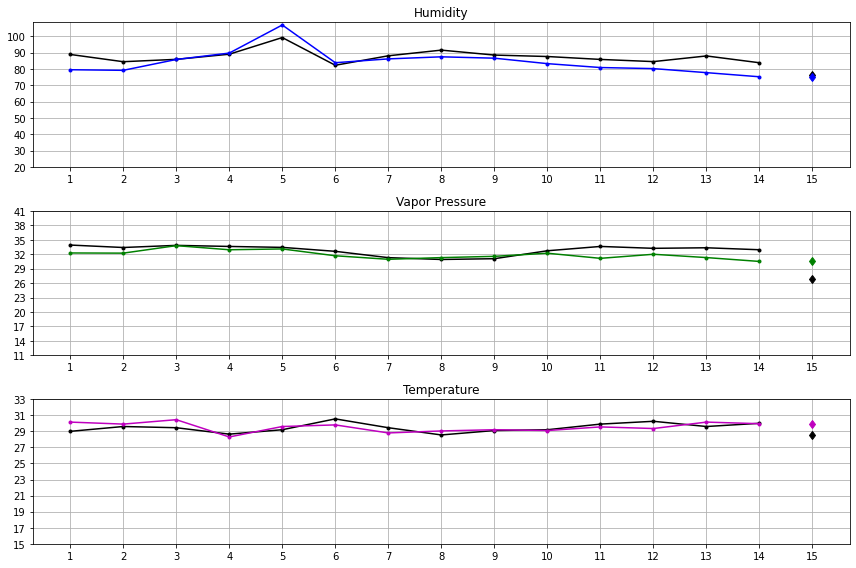

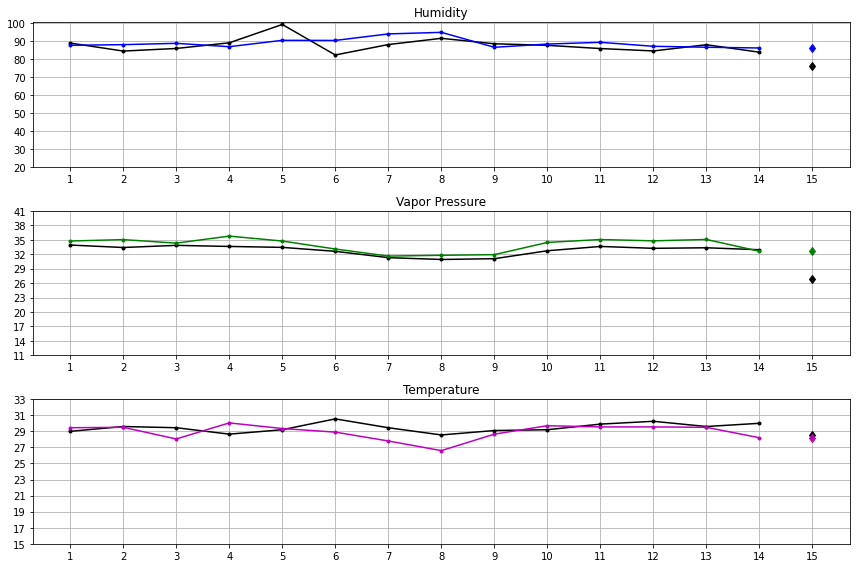

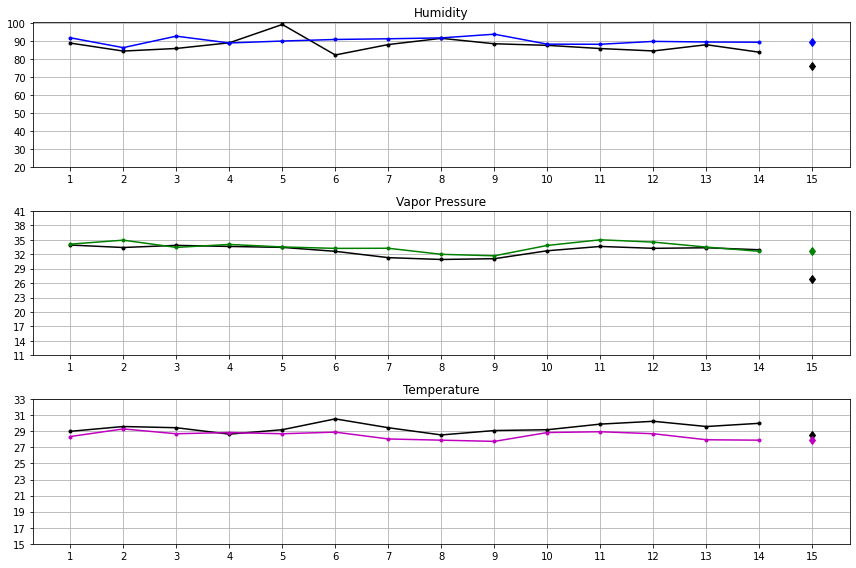

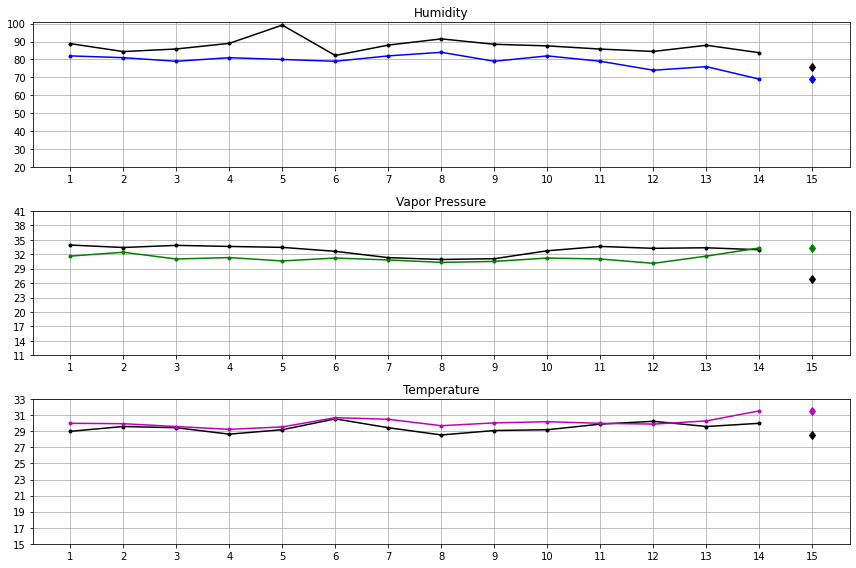

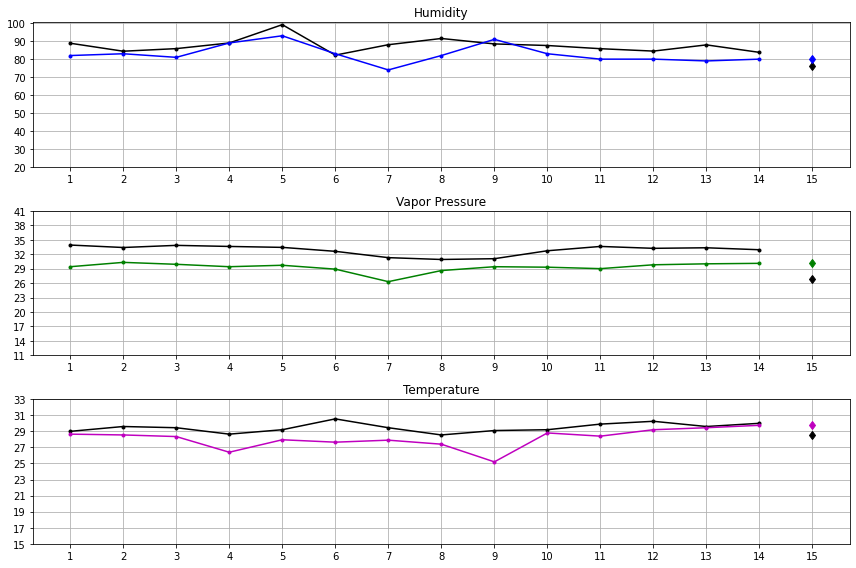

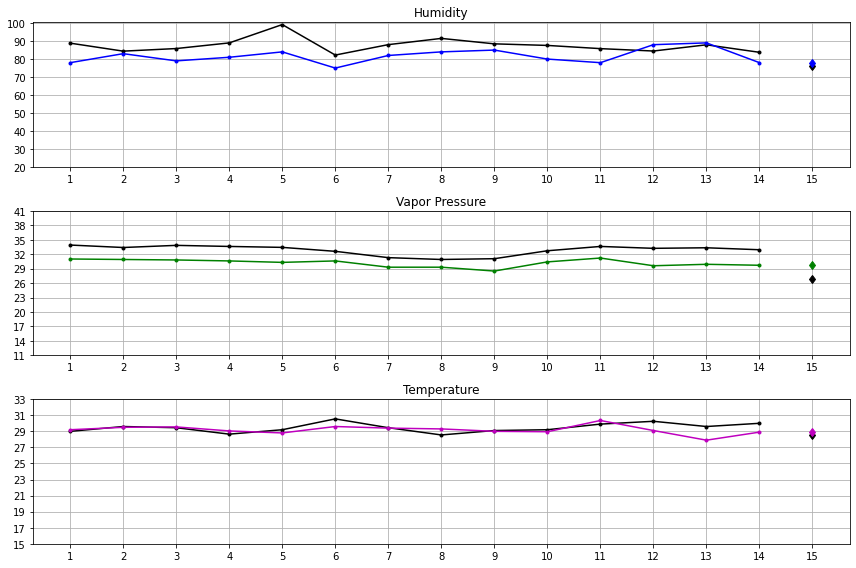

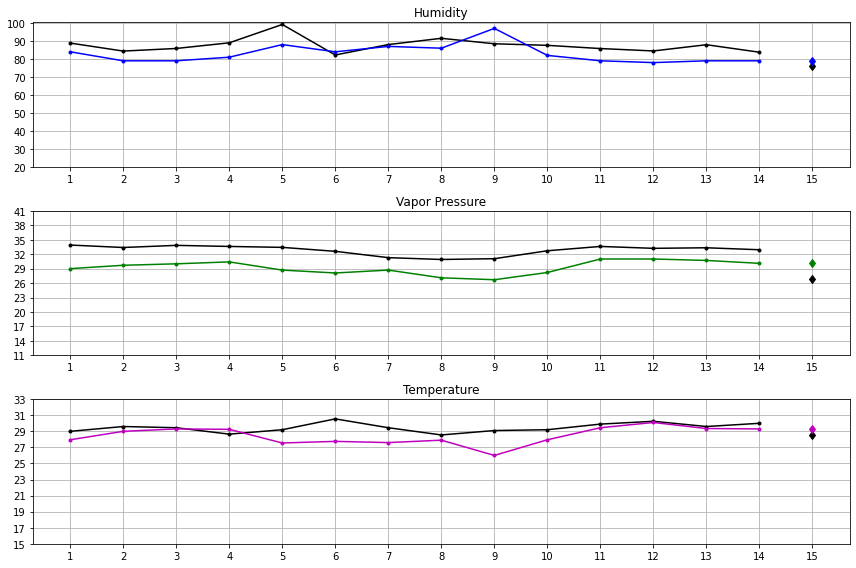

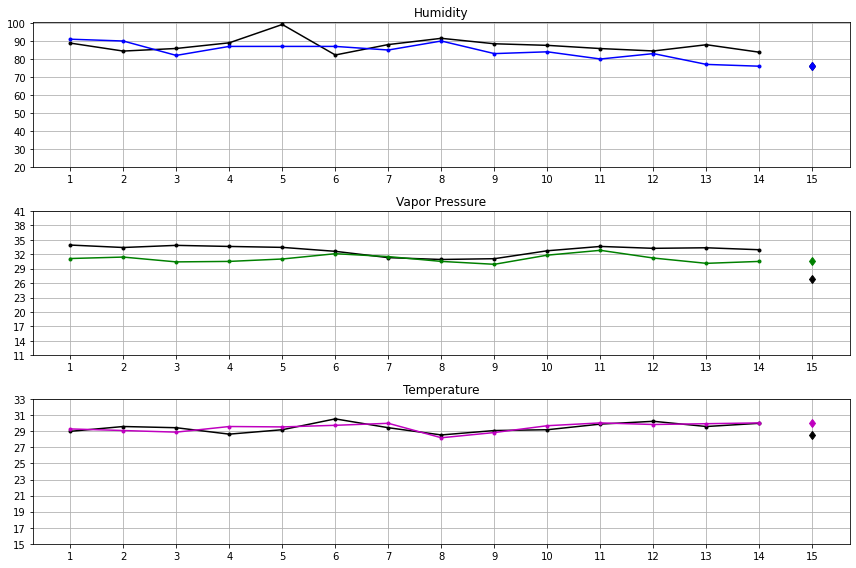

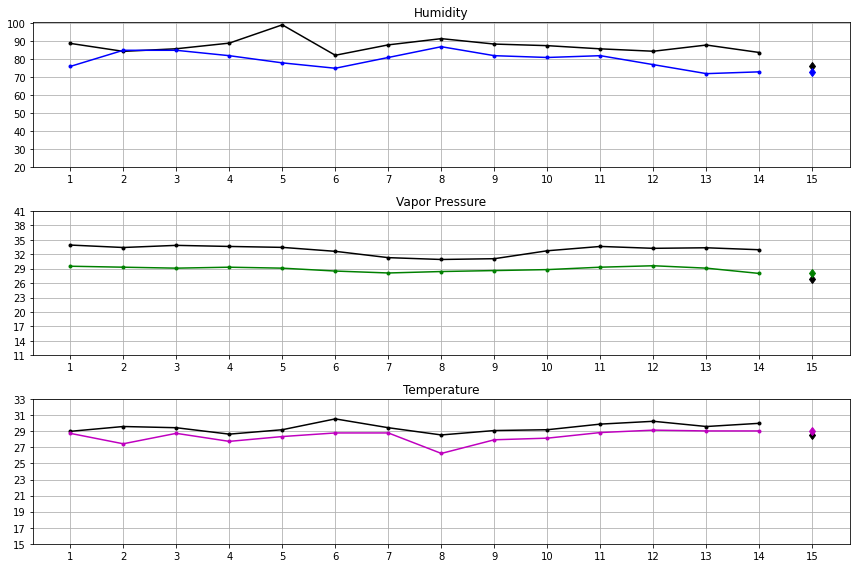

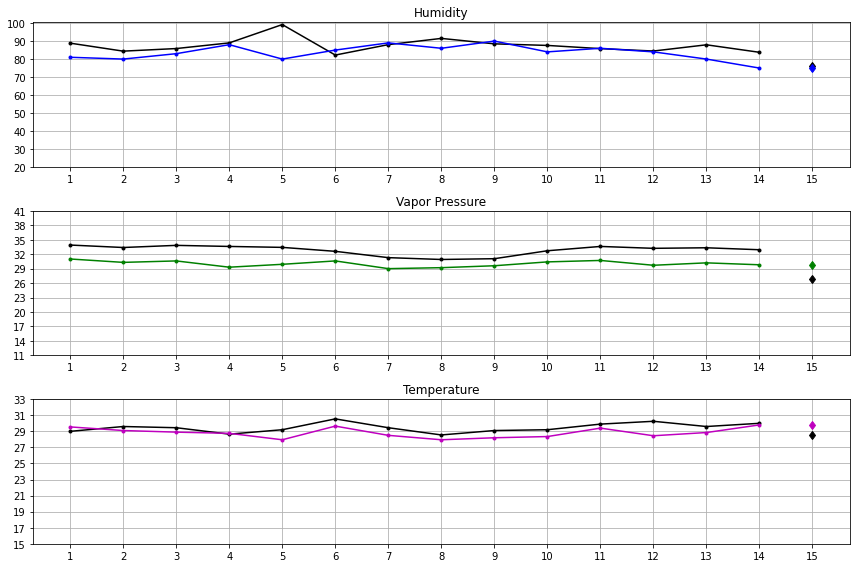

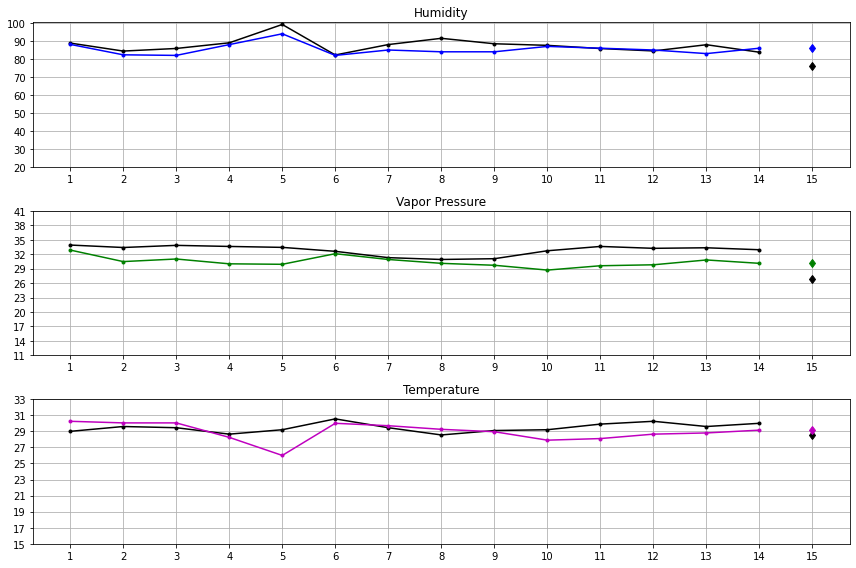

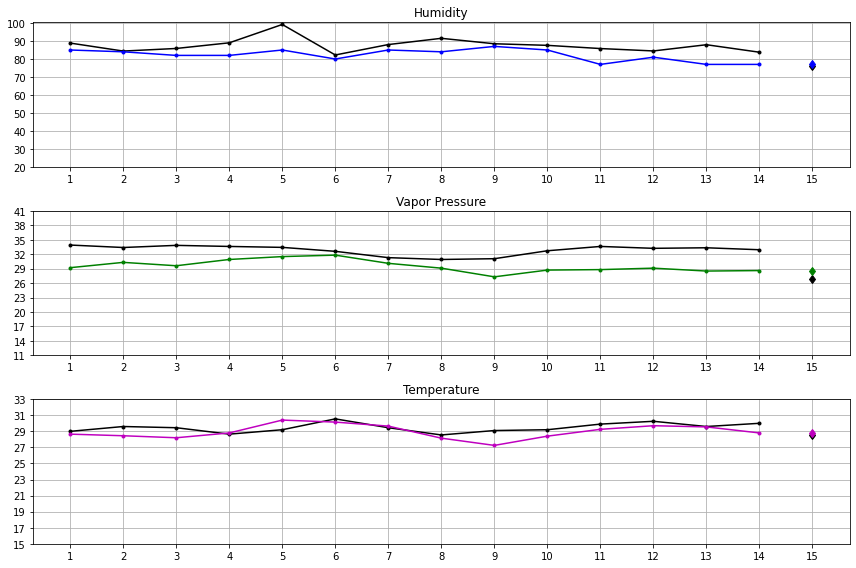

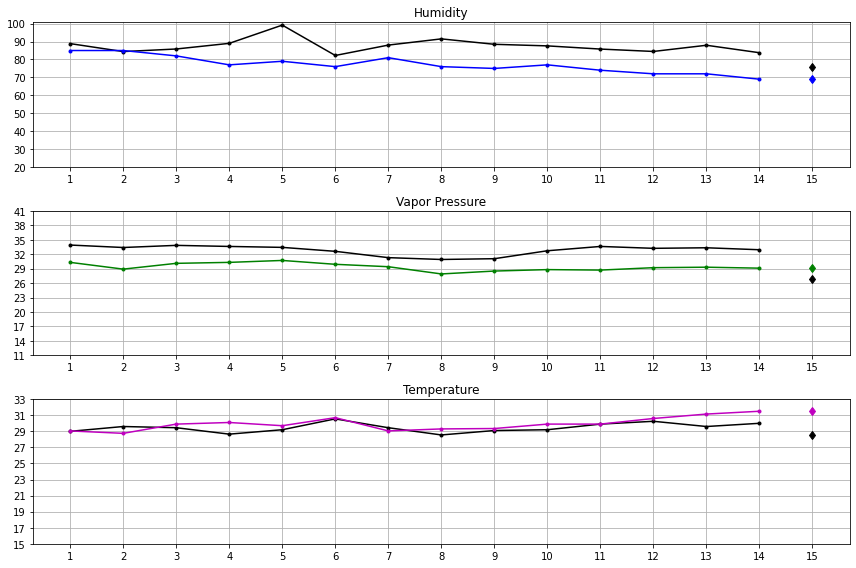

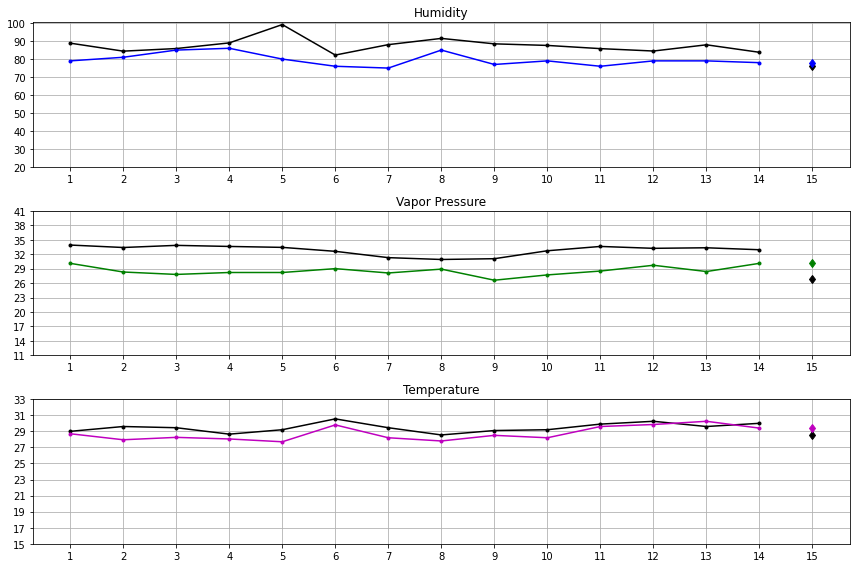

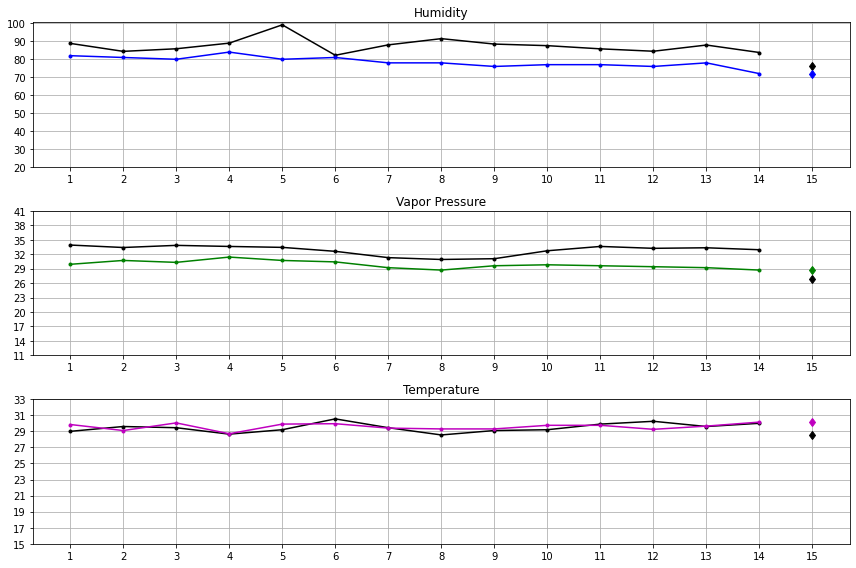

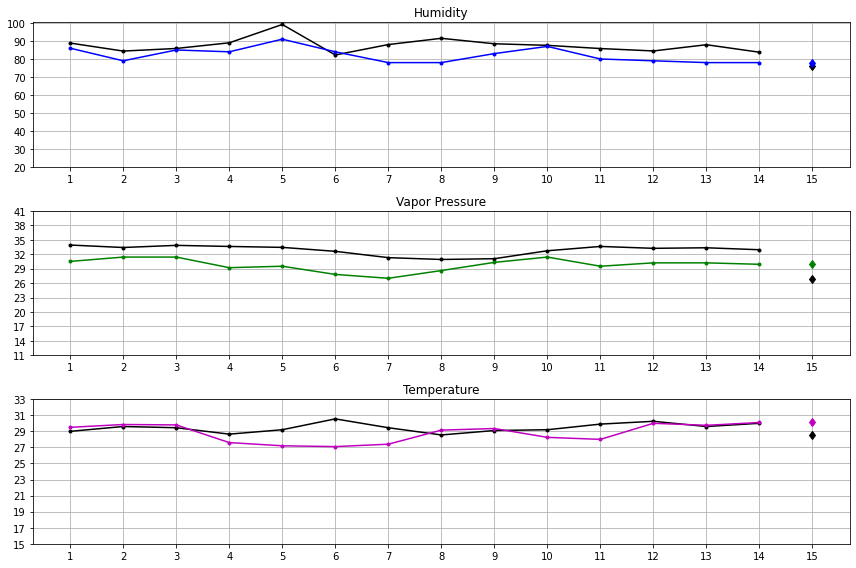

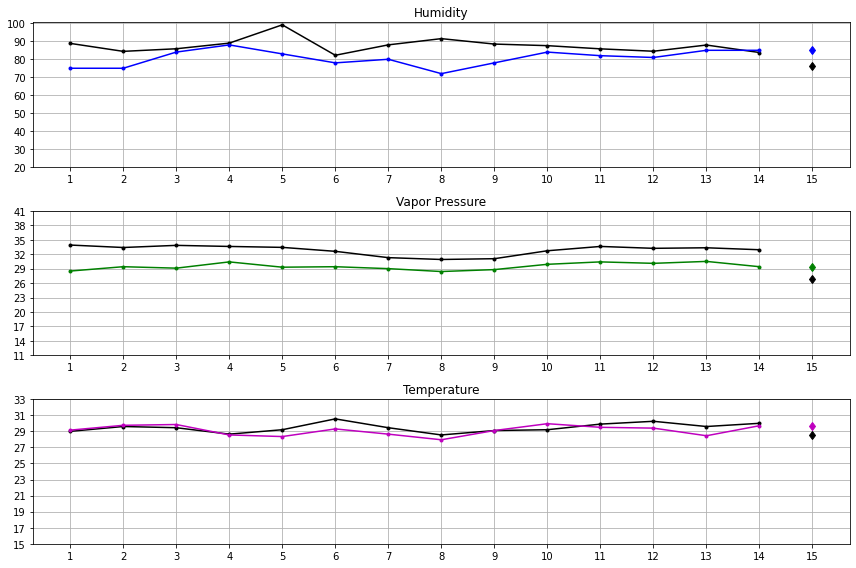

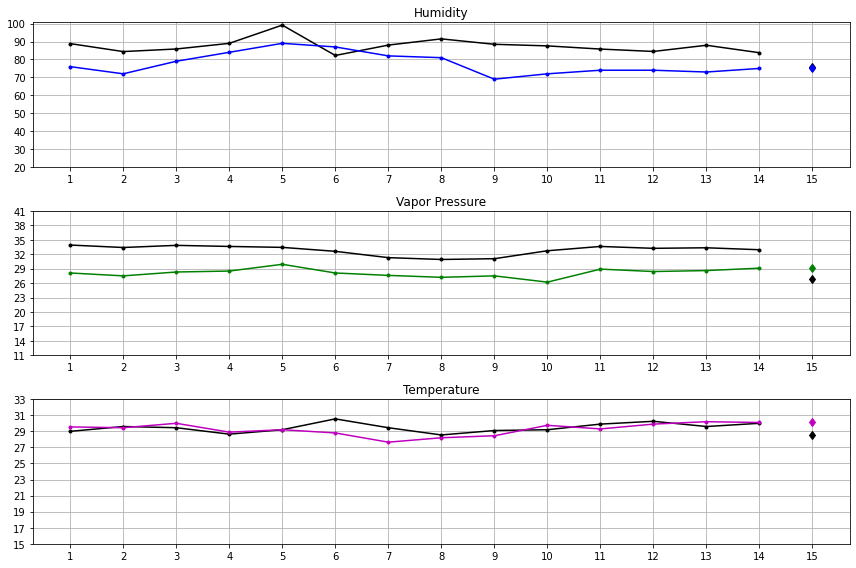

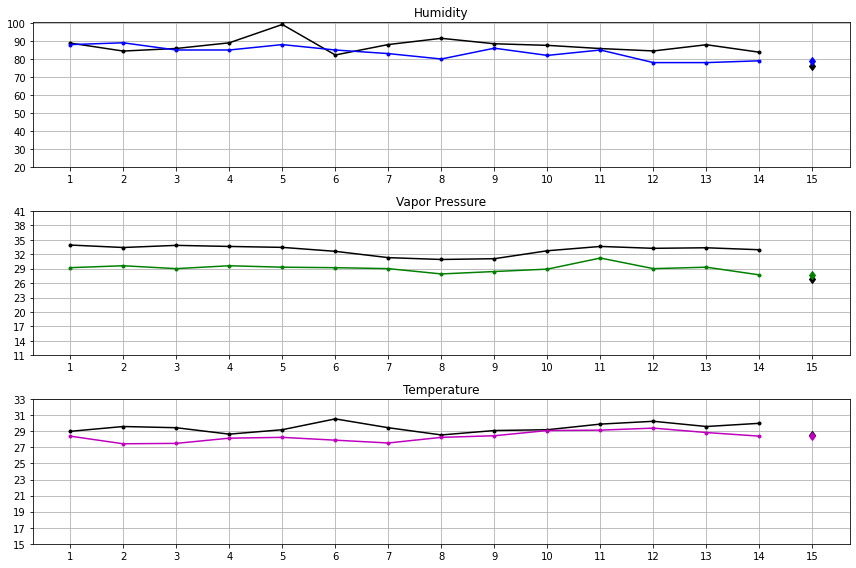

In [45]:

cont=np.arange(1,windowLen+1)
explicationMethodResult = 0
if explicationMethodResult == 0:
    notCombinedOption()
else:
    combinedOption()

In [46]:
stati,pValue = scipy.stats.mannwhitneyu(bestMAE, worstMAE, method="asymptotic")
pValue

1.4798065133032065e-07